Design variables

In [8]:
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# define design variables
dt = 1 # timestep [hours]
ti = 0 # initial time [hours]
tf = 24 # final time [hours]
t = np.arange(ti,tf,dt)

num_shiftable_appliances = 3 # charger, HVAC, water heater

x_size = [t.size * num_shiftable_appliances, 1]
x0 = np.zeros(x_size)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
cd /content/drive/MyDrive/Hackathon\ Nov\ 11

/content/drive/.shortcut-targets-by-id/1MzTCZX3iy1y6it79u3H_p-H7C14dlu9Y/Hackathon Nov 11


In [11]:
from astropy.table import Table, Column
import datetime
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os

import pdb # debug


rootdir_nicholas = 'Data/chunked_data/'

def read_table(id, rootdir=rootdir_nicholas):
    """
    Takes in: a float. Reads the corresponding time series data from {rootdir}TimeSeriesVariable{float}

    Calculates new columns:
    year - year
    month - month (1 thru 12)
    day - day in a month (i.e., 1 thru 31)
    weekday - 0 (Monday) thru 6 (Sunday) - using datetime module
    time - float; hours since midnight
    """
    # Read in the table
    if os.path.exists(f'{rootdir}TimeSeriesVariable{id}.txt'):
        data = Table.read(f'{rootdir}TimeSeriesVariable{id}.txt', format='ascii')

        # parse the year, month, day; and hours (float) since midnight
        N = len(data)
        year_str_list = [data['dateTime'][ii].split('T')[0] for ii in range(N)]
        year_list = [int(year_str_list[ii].split('-')[0]) for ii in range(N)]
        month_list = [int(year_str_list[ii].split('-')[1]) for ii in range(N)]
        day_list = [int(year_str_list[ii].split('-')[2]) for ii in range(N)]

        day_str_list = [data['dateTime'][ii].split('T')[1][:-1] for ii in range(N)]
        time_list = [float(day_str_list[ii].split(':')[0]) + float(day_str_list[ii].split(':')[1])/60 + float(day_str_list[ii].split(':')[2])/3600 for ii in range(N)]

        # Calculate weekday
        weekday_list = [datetime.date(year_list[ii],month_list[ii],day_list[ii]).weekday() for ii in range(N)]

        # Add columns
        data.remove_column('dateTime')
        data.add_column(Column(year_list, name='year'))
        data.add_column(Column(month_list, name='month'))
        data.add_column(Column(day_list, name='day'))
        data.add_column(Column(time_list, name='time'))
        data.add_column(Column(weekday_list, name='weekday'))


        # Reorder, for aesthetics
        data = data['year', 'month', 'day', 'weekday', 'time', 'data']
    else:
        data = Table(names=['year', 'month', 'day', 'weekday', 'time', 'data'])

    return data


class Building:
    def __init__(self, buildingno):
        """
        Building class. Initialized with building number. Keep adding attributes
        as needed...
        
        attributes:
        * buildingno = int, labels building
        * households = list of dicts with attributes for each person (length = people)
        * amenity_counts = dict, gives the raw number of things (i.e., counts['Boiler'] is the number of boilers TOTAL)
        * air_temperature_ids = list of IDs of air temperature TSVs (TimeSeriesVariables)
        * meter_electrical_power_ids = list of IDs of electrical power TSVs for METERS
        * plug_electrical_power_ids = list of IDs of electrical power TSVs for PLUGS
        """
        self.buildingno = buildingno
        
        url = '{http://www.refitsmarthomes.org}'
        
        # Read XML and loop through root to grab all attributes wanted
        xml_data = open(f'Data/REFIT_BUILDING_SURVEY.xml', 'r').read()  # Read file
        root = ET.XML(xml_data) # Parse XML
        root = root[0] # get to "Stock"
        
        # Get root to building (note index=0 is climate)
        root = root[buildingno+1]
        
        # Grab households
        household_root = root.find('./' + url + 'Household')
        
        self.households = []
        for person in household_root:
            self.households.append(person.attrib)
        
        # Create dictionary with *COUNTS* for number of things
        item_types = ['Boiler', 'Meter', 'Space', 'Appliance', 'Cooker',
                      'WaterOutlet', 'FixedHeater', 'Light', 'Plug', 'Radiator',
                      'RoomThermostat', 'Surface']
        self.amenity_counts = {}
        
        for item in item_types:
            self.amenity_counts[item] = len(root.findall('./' + url + f'{item}'))
        
        # Loop through sensors
        #sensors = root.findall('.//' + url+ 'Sensor')
        spaces = root.findall('.//' + url+ 'Space')
        self.air_temperature_ids = []
        
        for space in spaces:
            for sensor in space:
                for TSV in sensor: # time series variable
                    if 'conditionType' in space.attrib:
                      if (TSV.attrib['variableType'] == 'Air temperature'):# and (space.attrib['conditionType'] == 'Heated'):
                          idstr = TSV.attrib['id']
                          id = int(TSV.attrib['id'].replace('TimeSeriesVariable',''))
                          self.air_temperature_ids.append(id)
                
        # Loop through meters
        self.meter_electrical_power_ids = []
        meters = root.findall('.//' + url+ 'Meter')
        
        for meter in meters:
            for sensor in meter:
                for TSV in sensor:
                    if TSV.attrib['variableType'] == 'Electrical power':
                        idstr = TSV.attrib['id']
                        id = int(TSV.attrib['id'].replace('TimeSeriesVariable',''))
                        self.meter_electrical_power_ids.append(id)
        
        # Loop through plugs
        self.plug_electrical_power_ids = []
        plugs = root.findall('.//' + url+ 'Plug')
        
        for plug in plugs:
            for sensor in plug:
                for TSV in sensor:
                    if TSV.attrib['variableType'] == 'Electrical power':
                        idstr = TSV.attrib['id']
                        id = int(TSV.attrib['id'].replace('TimeSeriesVariable',''))
                        self.plug_electrical_power_ids.append(id)
    
        # Building materials
        self.cavityWallInsulationPresent = root.attrib['cavityWallInsulationPresent']
        self.loftInsulationType = root.attrib['loftInsulationType']
        if 'windowType' in root.attrib:
            self.windowType = root.attrib['windowType']
        else:
            self.windowType = 'Single glazed - Metal'
        
        # Grab loft thickness... I will remove greater-than signs because we want to be pessimistic
        loftInsulationThickness = root.attrib['loftInsulationThickness']
        loftInsulationThickness = loftInsulationThickness.replace('mm', '')
        loftInsulationThickness = loftInsulationThickness.replace('>', '')
        self.loftInsulationThickness_mm = float(loftInsulationThickness)
        
        # Get total surface area of (1) roof, (2) external walls, (3) floor, (4) windows, (5) door.
        # the last two are "openings",  not "surfaces"
        # all areas are in METERS SQUARED!!
        self.roof_area_m2 = 0
        self.wall_area_m2 = 0
        self.floor_area_m2 = 0
        self.window_area_m2 = 0
        self.door_area_m2 = 0
        
        surfaces = root.findall('.//' + url + 'Surface')
        for surface in surfaces:
            surfaceType = surface.attrib['surfaceType']
            area = float(surface.attrib['area'])
            if 'External' in surfaceType:
                if surfaceType == 'External roof':
                    self.roof_area_m2 += area
                if surfaceType == 'External wall':
                    self.wall_area_m2 += area
                if surfaceType == 'External floor':
                    self.floor_area_m2 += area
        
                # Search for openings, but only if external
                openings = surface.findall('.//' + url + 'Opening')
                for opening in openings:
                    openingType = opening.attrib['openingType']
                    area_opening = float(opening.attrib['area'])
                    if openingType == 'Window':
                        self.window_area_m2 += area_opening
                    if openingType == 'Door':
                        self.door_area_m2 += area_opening
        
        # Types of loft insulation:
        # - 'Mineral wool/fibre glass'
        # - 'Rigid board foam'
        # - 'Vermiculite beads'
        # - 'High performance quilt'
        # - 'Unknown'
        
        # Window types:
        # - 'Double glazed - UPVC'
        # - 'Single glazed - Wood casement'
        # - 'Single glazed - Metal'
        # - 'Double glazed - Wood'
        
        # Floor is probably made out of some shit idk
        # Doors are probably just wood, just assume some standard thickness
        
        # Go into dictionary, grab thermal diffusivities
        # we first define these dictionaries; values in W/m/K
        self.loft_k = {'Mineral wool/fibre glass': 0.035,
                       'Rigid board foam': 0.028,
                       'Vermiculite beads': 0.1530,
                       'High performance quilt': 0.043,
                       'Unknown': 0.1530}
        self.window_k = {'Double glazed - UPVC': 0.024,
                         'Single glazed - Wood casement': 1.05,
                         'Single glazed - Metal': 1.05,
                         'Double glazed - Wood': 0.024}
        self.wall_k = {'Yes': 0.022, # if cavity-insulated
                       'No': 0.2}
        self.door_k = {'wood lmao': 0.2}
        
        # If there is a water cylinder, grab its R and H.
        # if not, assume the lowest possible values of R and H to still estimate the cooldown
        # time this way... pessimistically
        cylinders = root.findall('.//' + url + 'HotWaterCylinder')
        self.hotWaterCylinderDict_k = {'Jacket loose': 0.06923,
                                       'Foam factory packed': 0.028}
        
        if len(cylinders) != 0:
            if 'cylinderSize' in cylinders[0].attrib:
                cyl_str = cylinders[0].attrib['cylinderSize']
                cyl_str = cyl_str.replace('mm','').split(' x ')
                cyl_radius = float(cyl_str[0]) / 2
                cyl_height = float(cyl_str[1])
            else:
                cyl_radius = 450 / 2
                cyl_height = 900
            
            self.hotWaterCylinderRadius_mm = cyl_radius
            self.hotWaterCylinderHeight_mm = cyl_height
            
            if 'cylinderInsulationType' in cylinders[0].attrib:
                cylinderInsulationType = cylinders[0].attrib['cylinderInsulationType']
            else:
                cylinderInsulationType = 'Jacket loose'
            self.hotWaterCylinder_k = self.hotWaterCylinderDict_k[cylinderInsulationType]
            
            if 'cylinderInsulationThickness' in cylinders[0].attrib:
                self.cylinderInsulationThickness_mm = float(cylinders[0].attrib['cylinderInsulationThickness'].replace('mm',''))
            else:
                self.cylinderInsulationThickness_mm = 12.5
        else:
            self.hotWaterCylinderRadius_mm = 450 / 2
            self.hotWaterCylinderHeight_mm = 900
            self.hotWaterCylinder_k = self.hotWaterCylinderDict_k['Jacket loose']
            self.cylinderInsulationThickness_mm = 12.5
        
        self.cylinderVolume_m3 = np.pi * self.hotWaterCylinderRadius_mm ** 2 * self.hotWaterCylinderHeight_mm * 1e-3**3

        # Get volume of all the heated spaces
        self.total_heated_volume = 0
        spaces = root.findall('.//' + url + 'Space')
        for space in spaces:
            if 'conditionType' in space.attrib:
                if space.attrib['conditionType'] == 'Heated':
                    self.total_heated_volume += float(space.attrib['volume'])
    
    def get_heat_loss(self, dT):
        """
        given dT (temperature difference in degrees C/K), returns heat
        loss (in Watts; this is a POWER). Call this 'Q':
        
        Q = area * dT * conductivity k / thickness
        
        delta_T is the same sign as the heat transfer
        """
        Q = 0
        
        # Loft
        Q += self.roof_area_m2 * dT * self.loft_k[self.loftInsulationType] / (1e-3 * self.loftInsulationThickness_mm)
        
        # Walls
        wall_thickness_m = 50e-3
        Q += self.wall_area_m2 * dT * self.wall_k[self.cavityWallInsulationPresent] / wall_thickness_m
        
        # Windows
        window_thickness_m = 6.35e-3
        Q += self.window_area_m2 * dT * self.window_k[self.windowType] / window_thickness_m
        
        # Doors
        door_thickness_m = 44.45e-3
        Q += self.door_area_m2 * dT * self.door_k['wood lmao'] / door_thickness_m
        
        # Floor; should acct. for 15% of the loss
        Q *= 1.18
        
        return Q
    
    def get_ramp_up_rate_water(self, power_in, dT):
        """
        Get ramp up rate (s^-1), given power (in W) to |dT| (difference between "hot" and room temperature)
        """
        rho_water = 1e3 # SI
        Cv = 4.18e3 # heat cap/kg
        Vsh = 0.0598 # shower water volume: https://home-water-works.org/indoor-use/showers#:~:text=The%20average%20American%20shower%20uses,per%20minute%20(7.9%20lpm).
        
        dt = rho_water*Cv*self.cylinderVolume_m3*dT/power_in
        
        # https://redcapplumbing.com/help-guides/troubleshooting/how-long-does-it-take-a-water-heater-to-recover ~ 1 hr
        # 2 hr?
        #dt = 3600
        
        return 1/dt
    
    def get_ramp_down_rate_water(self, showering=False):
        """
        Get ramp down rate (s^-1) - only depends on if showering or not
        """
        #rho_water = 1e3 # SI
        #Cv = 4.18e3 # heat cap/kg
        
        #pdb.set_trace()
        #dt = rho_water * Cv * (self.cylinderInsulationThickness_mm*1e-3) * (1/(self.hotWaterCylinderRadius_mm*1e-3) + 2/(self.hotWaterCylinderHeight_mm*1e-3)) ** -1 / (self.hotWaterCylinder_k)
        # something is underestimated here... just use a kludgy value for now
        # https://redcapplumbing.com/help-guides/troubleshooting/how-long-does-it-take-a-water-heater-to-recover ~ 1 hr
        
        # If showering, this has to be changed to something low; dt ~ 
        if showering:
            dt = 7.*60
            return dt ** -1
        else:
            return 0

    def get_mc_water(self):
        """
        Water mc
        """
        rho_water = 1e3 # SI
        Cv = 4.18e3 # heat cap/kg
        Vsh = 0.0598 # shower water volume: https://home-water-works.org/indoor-use/showers#:~:text=The%20average%20American%20shower%20uses,per%20minute%20(7.9%20lpm).
        
        return rho_water*Cv*self.cylinderVolume_m3#Vsh

In [12]:
building = Building(3)

Parameters

In [13]:
# define parameters
voltage = 120 # voltage [V rms]
current_max = 100 # maximum allowed current [A rms]
p = {}

p['P_max'] = voltage * current_max # maximum allowed power [W]

p['nt'] = t.size
p['t'] = t

unshiftable = Table.read('Data/currents.csv')
total = Column(unshiftable['washer']+unshiftable['dryer']+unshiftable['misc']+unshiftable['dish']+unshiftable['kitchen'], name='actualtotal')
unshiftable.add_column(total)
unshiftable_interp = interp1d(unshiftable['time'] / 60,  voltage * unshiftable['actualtotal'], bounds_error=False, fill_value=0)
p['unshiftable_load'] = unshiftable_interp(t)

p['weights'] = np.ones([num_shiftable_appliances, 1])                 # weights for how much impact a given discomfort is worth for each appliance

p['P_max_charger'] = 4800 # W
p['P_max_hvac'] = 4500 # W
p['P_max_water'] = 4400 # W
p['P_min_charger'] = -p['P_max_charger'] # allow vehicle to grid charging
p['P_min_hvac'] = -p['P_max_hvac'] # W (negative power represents AC, positive for heating)
p['P_min_water'] = 0

p['P_solar_forcing'] = 5000 # W (depends on time of year)
p['T_outside'] = 30 # deg C (depends on time of year)

p['car_charge_desired'] = 2.7e8 # J
p['room_temp_desired'] = 23 # deg C
p['water_temp_desired'] = 50 # deg C

p['hours_car'] = 7                     # 7am
p['hours_hvac'] = 1.0 * np.arange(12+5,12+11,1) # 5pm to 11pm
p['hours_water'] = 12+8                # 8pm

p['mc_hvac'] = 3600 * 4500 * (building.total_heated_volume / 400)
p['mc_water'] = building.get_mc_water() # scaled to a single shower...
p['hA_hvac'] = building.get_heat_loss(1)
p['hA_water'] = p['mc_water'] / (3600 * 24) # setting the decay time to a day

p['state0'] = [p['car_charge_desired']/2, p['room_temp_desired'], p['water_temp_desired']]


In [14]:
# Second vector of parameters, p2
p2 = p.copy()

np.random.seed(1171962) # Jim Carrey's birthday
sigma = 0.05
Tamplitude = 3 # amplitude of temperature deviations
hramplitude = 1 # amplitude of hour variations

p2['unshiftable_load'] *= np.random.normal(1, sigma, size=np.shape(p2['unshiftable_load']))
p2['weights'] *= np.random.normal(1, sigma, size=np.shape(p2['weights']))  
p2['P_max_charger'] *= np.random.normal(1, sigma)

p2['P_max_charger'] *= np.random.normal(1, sigma)
p2['P_max_hvac'] *= np.random.normal(1, sigma)
p2['P_max_water'] *= np.random.normal(1, sigma)
p2['P_min_charger'] = -p2['P_max_charger'] # allow vehicle to grid charging
#p['P_min_water'] = 0 # unchanged

p2['P_solar_forcing'] *= np.random.normal(1, sigma)
p2['T_outside'] += Tamplitude * np.random.normal(1, sigma) # deg C (depends on time of year)

p2['car_charge_desired'] *= np.random.normal(1, sigma)
p2['room_temp_desired'] += Tamplitude * np.random.normal(1, sigma)
p2['water_temp_desired'] += Tamplitude * np.random.normal(1, sigma)

p2['hours_car'] += hramplitude * np.random.normal(1, sigma)
p2['hours_hvac'] += hramplitude * np.random.normal(1, sigma, size=np.shape(p2['hours_hvac']))
p2['hours_water'] += hramplitude * np.random.normal(1, sigma)

p2['mc_hvac'] *= np.random.normal(1, sigma)
p2['mc_water'] *= np.random.normal(1, sigma)
p2['hA_hvac'] *= np.random.normal(1, sigma)
p2['hA_water'] *= np.random.normal(1, sigma)

p2['state0'] = [p2['car_charge_desired']/2, p2['room_temp_desired'], p2['water_temp_desired']]

Constraints and objective

In [15]:
# define constraints

ub_power = np.ones([t.size, 1]) * p['P_max']
lb_power = 0
A_power = np.tile(np.eye(t.size), num_shiftable_appliances)

total_power_constraint = {}
total_power_constraint['fun'] = lambda x: np.max([ub_power - A_power*np.abs(x)])
total_power_constraint['type'] = 'ineq'

def state_invalid(x,p):
  state = dynamics(x,p,t)
  car_charge = state[:,0]
  state_invalid = np.max([p['car_charge_desired'] - car_charge, car_charge])
  return state_invalid

battery_state_constraint = {}
battery_state_constraint['fun'] = state_invalid
battery_state_constraint['type'] = 'ineq'
battery_state_constraint['args'] = (p,)

lb_charge = np.ones([t.size,1]) * p['P_min_charger']
lb_hvac = np.ones([t.size,1]) * p['P_min_hvac']
lb_water = np.ones([t.size,1]) * p['P_min_water']
lb = np.append(lb_charge, [lb_hvac, lb_water])

ub_charge = np.ones([t.size,1]) * p['P_max_charger']
ub_hvac = np.ones([t.size,1]) * p['P_max_hvac']
ub_water = np.ones([t.size,1]) * p['P_max_water']
ub = np.append(ub_charge, [ub_hvac, ub_water])

# define objective
def impact_of_shift(x,p,t):
  state = dynamics(x,p,t)  # state = SOC of car, temp of room, temp of hot water
  state = state.T

  # states at relevant hours
  car_charge = state[p['hours_car'],0]
  room_temp  = state[p['hours_hvac'].astype(int),1]
  water_temp = state[p['hours_water'],2]

  # discomfort
  discomfort_car = np.mean(p['car_charge_desired'] - car_charge)
  discomfort_hvac = np.mean((room_temp - p['room_temp_desired'])**2)
  discomfort_water = np.mean((water_temp - p['water_temp_desired'])**2)
  discomfort = np.array([discomfort_car, discomfort_hvac, discomfort_water])

  impact = np.dot(discomfort, p['weights'])           # weighted impact of discomfort
  return impact

def dynamics(x,p,t):
  # heating dynaimcs, based on house type etc
  t_sec = t * 3600 # hours to seconds
  sol = solve_ivp(rate, (0,np.max(t_sec)), p['state0'], t_eval = t_sec, args=(x,p), vectorized=False)
  state = sol.y
  return state

interp_fcn = interp1d(t,np.arange(0,p['nt'],1))


def rate(t,state,x,p):
  interp_power_charger = interp1d(p['t'], x[:p['nt']])
  interp_power_HVAC = interp1d(p['t'], x[p['nt']:2*p['nt']])
  interp_power_water = interp1d(p['t'], x[2*p['nt']:])

  power_charger = interp_power_charger(t/3600)
  power_HVAC    = interp_power_HVAC(t/3600)
  power_water   = interp_power_water(t/3600)

  T_hvac  = state[1]
  T_water = state[2]
  power_loss_hvac  = p['hA_hvac']  * (T_hvac - p['T_outside'])
  power_loss_water = p['hA_water'] * (T_water - T_hvac)

  E_dot_charger = power_charger
  T_dot_hvac    = 1/p['mc_hvac']  * (power_HVAC - power_loss_hvac + p['P_solar_forcing'])
  T_dot_water   = 1/p['mc_water'] * (power_water - power_loss_water)
  # this currently does not account for hot water being used!

  
  dstate_dt = np.append(E_dot_charger, [T_dot_hvac, T_dot_water])
 
  return dstate_dt

Run planner and controller

In [16]:
# run planner (solve feed-forward optimization)
sol = minimize(impact_of_shift, x0, args = (p, t), bounds = Bounds(lb,ub), 
                constraints = (total_power_constraint, battery_state_constraint))


# run real-time controller (
#x_rt = (impact_of_shift, x_ff)

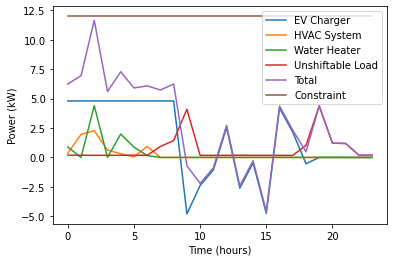

In [17]:
power = sol.x

power1 = power[0:p['nt']]
power2 = np.abs(power[p['nt']:2*p['nt']])
power3 = power[p['nt']*2:]

plt.plot(t,power1/1000,label='EV Charger')
plt.plot(t,power2/1000,label='HVAC System')
plt.plot(t,power3/1000,label='Water Heater')
plt.plot(t,p['unshiftable_load']/1000,label='Unshiftable Load')
plt.plot(t,(power1+power2+power3+p['unshiftable_load'])/1000,label='Total')
plt.plot(t,np.ones([t.size])*p['P_max']/1000,label='Constraint')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Power (kW)')
plt.savefig('GoodPlot.png')